In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import healpy.visufunc as hpVis

from astropy.coordinates import SkyCoord

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (9.0, 7.5)
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelcolor'] = "#000000"

The data for this notebook comes from the `createStarDensitymap.py` script in `sims_maf`. It computes a luminosity function of all stars from the sims database, and saves it in healpix pixels. The first few cells explore the format of the file that this script produced.

In [2]:
data = np.load("../python/starDensity_r_nside_64.npz")

In [3]:
data.keys()

['starDensity', 'bins', 'overMaxMask']

In [4]:
data['starDensity'].shape

(49152, 65)

In [5]:
data['bins']

array([ 15. ,  15.2,  15.4,  15.6,  15.8,  16. ,  16.2,  16.4,  16.6,
        16.8,  17. ,  17.2,  17.4,  17.6,  17.8,  18. ,  18.2,  18.4,
        18.6,  18.8,  19. ,  19.2,  19.4,  19.6,  19.8,  20. ,  20.2,
        20.4,  20.6,  20.8,  21. ,  21.2,  21.4,  21.6,  21.8,  22. ,
        22.2,  22.4,  22.6,  22.8,  23. ,  23.2,  23.4,  23.6,  23.8,
        24. ,  24.2,  24.4,  24.6,  24.8,  25. ,  25.2,  25.4,  25.6,
        25.8,  26. ,  26.2,  26.4,  26.6,  26.8,  27. ,  27.2,  27.4,
        27.6,  27.8,  28. ])

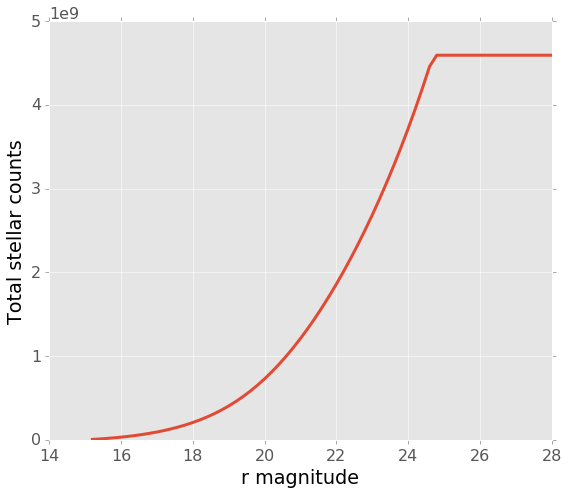

In [6]:
plt.plot(data['bins'][1:], np.sum(data['starDensity'], axis=0), '-', lw=3)
plt.ylabel("Total stellar counts")
plt.xlabel("r magnitude")

In `createStellarDensitymap.py` I imposed a cut in SQL at the single epoch r-band depth of 24.7, but just to be sure we also will impose the same cut on the luminosity functions returned by that script.

In [7]:
sel_magnitudes, = np.where(data['bins'] <= 24.7)
sum_density = np.sum(data['starDensity'][:,sel_magnitudes], axis=1)

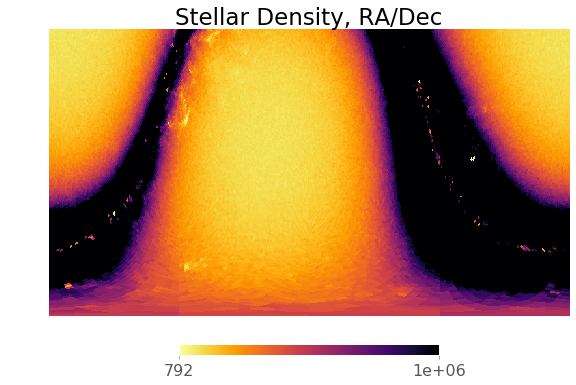

In [8]:
hpVis.cartview(sum_density, title="Stellar Density, RA/Dec", latra=(-90,30), aspect="auto",
               cbar=True, max=1e6, cmap="inferno_r")

Healpix is equal area (HEAL=Hierarchical Equal Area isoLatitude), so we get the pixel area by dividing $4 \pi$ by the number of pixels.

In [9]:
# In steradians
pixel_area_str = 4*np.pi/float(len(sum_density))

We define a $1''$ radius mask for each star. We will use this throughout the notebook, so changing to an alternate mask radius should be done here.

In [10]:
mask_radius_arcsec = 1.0
masked_area = sum_density * np.pi*(mask_radius_arcsec/206265.0)**2
masked_fraction = masked_area/pixel_area_str

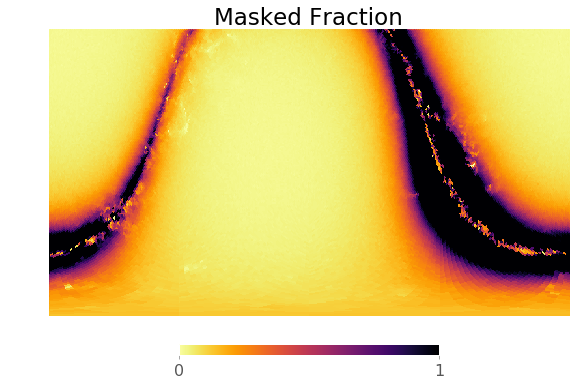

In [11]:
hpVis.cartview(masked_fraction, title="Masked Fraction", latra=(-90,35), cbar=True, max=1, cmap="inferno_r",
               aspect="auto")

As one can see on the map, the masked fraction is obviously a strong function of Galactic latitude. The next cell does some bookkeeping to give Galactic coordinates for each pixel.

In [12]:
nside = 64
theta, phi = hp.pix2ang(nside, np.arange(len(sum_density)))
ra = phi*180/np.pi
dec = (-theta + np.pi/2.0)*180/np.pi

equ_coords = SkyCoord(ra=ra, dec=dec, unit="deg", frame="icrs")
gal_coords = equ_coords.galactic

We impose a cut on declination for two reasons: (1) the database this is drawn from only has stars up to Dec of 35 degrees, so pixels above this limit are empty, and (2) we want our numbers to describe the actual LSST survey footprint. This cut will be worked into all following calculations in this notebook.

In [13]:
sel, = np.where(dec < 0)

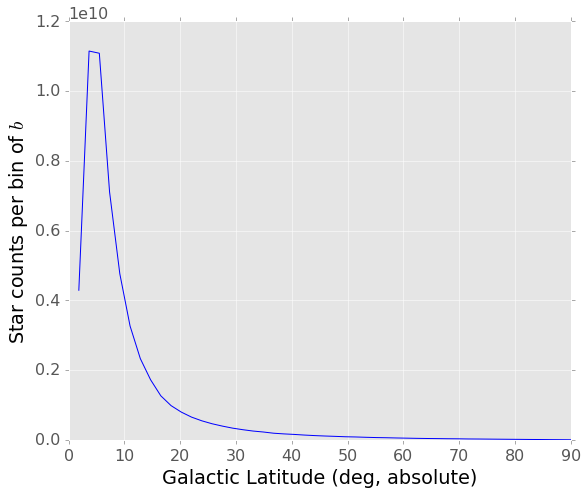

In [14]:
b_bins = linspace(0,90,50)
differential_counts,_ = np.histogram(np.abs(gal_coords.b.deg[sel]), weights=sum_density[sel], bins=b_bins)
plt.plot(b_bins[1:], differential_counts, 'b-')
plt.ylabel("Star counts per bin of $b$")
plt.xlabel("Galactic Latitude (deg, absolute)")

Cumulative Masked Area Fraction
===============================

Our ideal metric is this: What fraction of all observed area above some Galactic latitude would be lost by masking each star. 

To compute this, I take the histogram of stellar counts with latitude, and compute another histogram of the total area that was observable in each bin (passes the cut on declination $ <30^\circ$). I then transform both of these into cumulative histograms, starting at high Galactic latitude and summing towards the Galactic plane. The masked area can then be computed from the cumulative stellar counts, and the ratio of this masked area to total area is the masked fraction of the sky.

This first plot shows the cumulative star counts.

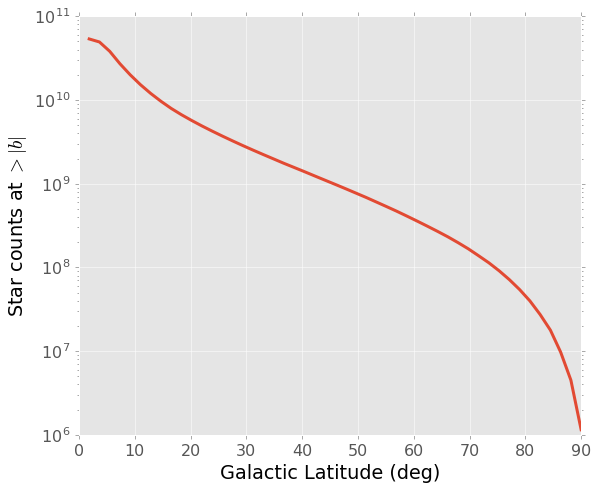

In [15]:
cumulative_counts = np.cumsum(differential_counts[::-1])
b_bin_areas,_ = np.histogram(np.abs(gal_coords.b.deg[sel]), weights=pixel_area_str*np.ones(len(sel)), bins=b_bins)
cumulative_area = np.cumsum(b_bin_areas[::-1])
plt.semilogy(b_bins[1:][::-1], cumulative_counts, '-', lw=3)
plt.ylabel("Star counts at $>|b|$")
plt.xlabel("Galactic Latitude (deg)")

Masked Area Fraction
--------------------

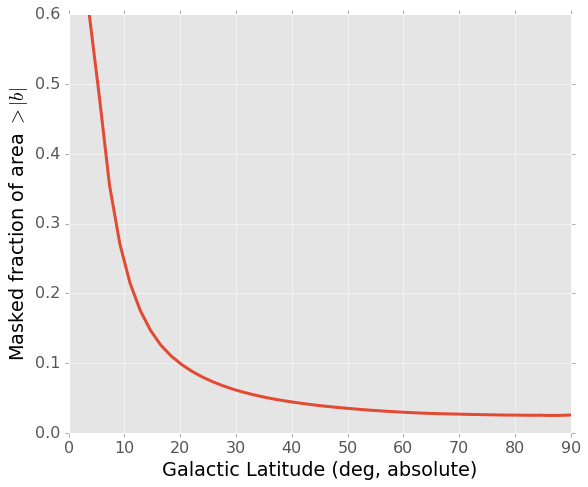

In [16]:
cumulative_masked_area = cumulative_counts * np.pi*(mask_radius_arcsec/206265.0)**2
cumulative_masked_fraction = cumulative_masked_area/cumulative_area
plt.plot(b_bins[1:][::-1], cumulative_masked_fraction, lw=3)

plt.ylim(0,0.6)
plt.xlabel("Galactic Latitude (deg, absolute)")
plt.ylabel("Masked fraction of area $>|b|$")


In [17]:
def find_masked_frac(lat):
    return cumulative_masked_fraction[np.argmin(np.abs(lat - b_bins[::-1]))]

for lat in [20,25,30,35,45]:
    print "Masked fraction at b > {:.0f}: {:.1f}%".format(lat, 100*find_masked_frac(lat))

Masked fraction at b > 20: 9.8%
Masked fraction at b > 25: 7.4%
Masked fraction at b > 30: 6.3%
Masked fraction at b > 35: 5.1%
Masked fraction at b > 45: 4.0%
